<a href="https://colab.research.google.com/github/mimilazarova/DD2424-covid-xray-project/blob/master/Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import os

In [0]:
# if scipy 1.2.0 is not already installed. 
!pip install scipy==1.2.0

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
with open('/content/drive/My Drive/DD2424_Project/data/testX.pickle', 'rb') as f:
  testX = pickle.load(f)
with open('/content/drive/My Drive/DD2424_Project/data/test_y.pickle', 'rb') as f:
  test_y = pickle.load(f)

testN = testX.shape[0]
testX = testX.reshape((testN, 224, 224, 1))
testX.shape

(231, 224, 224, 1)

In [0]:
#dirname = "/content/drive/My Drive/DD2424_Project/split-80-20-bs16-with-augmentation-weights-1-1-8"
#filename = "model8-3-augmentation-16-0.90-best-network.hdf5"

dirname = "/content/drive/My Drive/DD2424_Project/"
filename = "model8-undersampling-weights-augmentation-37-0.88.h5"
model = keras.models.load_model(os.path.join(dirname, filename))

preds_1hot = model.predict(testX)
preds = np.argmax(preds_1hot, axis=1)

conf_matrix = confusion_matrix(test_y, preds, labels=[0, 1, 2])
print("Test set")
print(conf_matrix)
print(classification_report(test_y, preds, digits=3))

Test set
[[95  5  0]
 [ 9 89  2]
 [ 2  2 27]]
              precision    recall  f1-score   support

           0      0.896     0.950     0.922       100
           1      0.927     0.890     0.908       100
           2      0.931     0.871     0.900        31

    accuracy                          0.913       231
   macro avg      0.918     0.904     0.910       231
weighted avg      0.914     0.913     0.913       231



# Grad-CAM visualization

In [0]:
import vis
from vis.utils import utils

# change activation of last layer
layer_idx = len(model.layers)-1
model.layers[layer_idx].activation = keras.activations.linear
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d_268 (Conv2D)             (None, 112, 112, 64) 3200        input_15[0][0]                   
__________________________________________________________________________________________________
batch_normalization_293 (BatchN (None, 112, 112, 64) 256         conv2d_268[0][0]                 
__________________________________________________________________________________________________
activation_213 (Activation)     (None, 112, 112, 64) 0           batch_normalization_293[0][0]    
____________________________________________________________________________________________

Using TensorFlow backend.


In [0]:
from vis.visualization import visualize_cam
penultimate_layer_idx = len(model.layers) - 11 # last conv layer

img_idx = 10
grad_top1 = visualize_cam(model, layer_idx, preds[img_idx], testX[img_idx],
                         penultimate_layer_idx  = penultimate_layer_idx,
                         backprop_modifier      = None,
                         grad_modifier          = None)

print(grad_top1.shape)

(224, 224, 3)


In [0]:
import cv2 as cv2
from vis.visualization import visualize_cam

def plot_map(grad_top, image, alpha=0.5):
  # change image to match grad_top
  image = 255*image
  image = image.astype('uint8')
  image = np.repeat(image, 3, 2)

  # superimpose the gard_top over image and plot
  final = cv2.addWeighted(grad_top, 0.5, image, 0.5, 0)
  plt.imshow(final)
  plt.show()

def plot_grad_cam(x, y, pred, alpha=0.5):
  penultimate_layer_idx = len(model.layers) - 11 # last conv layer

  grad_top = visualize_cam(model, layer_idx, pred, x,
                         penultimate_layer_idx  = penultimate_layer_idx,
                         backprop_modifier      = None,
                         grad_modifier          = None)
  
  grad_top = 
  
  print("Ground Truth Label: ", y)
  print("Prediction Label: ", pred)
  plot_map(grad_top, x, alpha)
  return grad_top

In [0]:
healthy = np.argwhere(test_y == 0)[:, 0]
pneumonia = np.argwhere(test_y == 1)[:, 0]
covid19 = np.argwhere(test_y == 2)[:, 0]

pred_healthy = np.argwhere(preds == 0)[:, 0]
pred_pneumonia = np.argwhere(preds == 1)[:, 0]
pred_covid19 = np.argwhere(preds == 2)[:, 0]

correct_healthy = np.intersect1d(healthy, pred_healthy, True)
correct_pneumonia = np.intersect1d(pneumonia, pred_pneumonia, True)
correct_covid19 = np.intersect1d(covid19, pred_covid19, True)

false_healthy = pred_healthy[np.in1d(pred_healthy, correct_healthy, True, True)]
false_pneumonia = pred_pneumonia[np.in1d(pred_pneumonia, correct_pneumonia, True, True)]
false_covid19 = pred_covid19[np.in1d(pred_covid19, correct_covid19, True, True)]

Ground Truth Label:  0
Prediction Label:  0


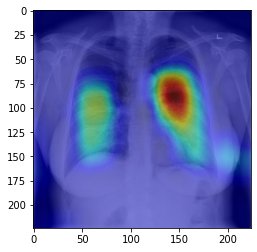

Ground Truth Label:  1
Prediction Label:  1


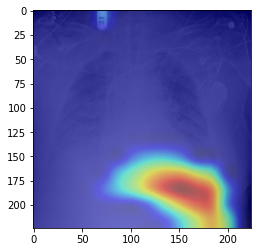

Ground Truth Label:  2
Prediction Label:  2


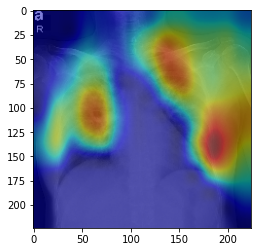

Ground Truth Label:  1
Prediction Label:  0


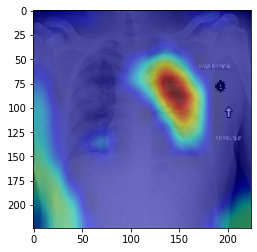

Ground Truth Label:  0
Prediction Label:  1


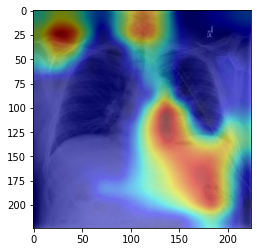

Ground Truth Label:  1
Prediction Label:  2


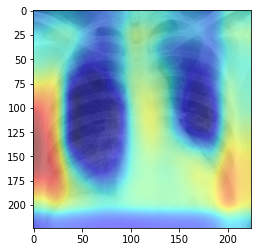

In [0]:
plot_grad_cam(testX[healthy[0]], test_y[healthy[0]], preds[healthy[0]])
plot_grad_cam(testX[pneumonia[0]], test_y[pneumonia[0]], preds[pneumonia[0]])
plot_grad_cam(testX[covid19[0]], test_y[covid19[0]], preds[covid19[0]])
plot_grad_cam(testX[false_healthy[0]], test_y[false_healthy[0]], preds[false_healthy[0]])
plot_grad_cam(testX[false_pneumonia[0]], test_y[false_pneumonia[0]], preds[false_pneumonia[0]])
plot_grad_cam(testX[false_covid19[0]], test_y[false_covid19[0]], preds[false_covid19[0]])

print()

Ground Truth Label:  2
Prediction Label:  2


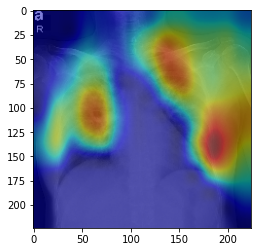

Ground Truth Label:  2
Prediction Label:  2


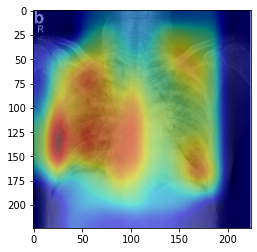

Ground Truth Label:  2
Prediction Label:  2


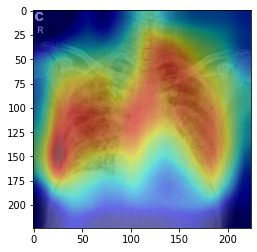

Ground Truth Label:  2
Prediction Label:  2


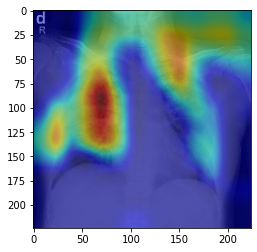

Ground Truth Label:  2
Prediction Label:  2


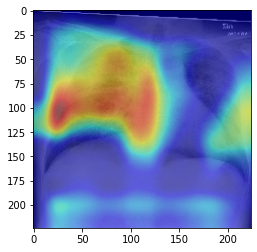

Ground Truth Label:  2
Prediction Label:  0


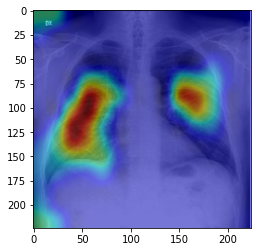

Ground Truth Label:  2
Prediction Label:  2


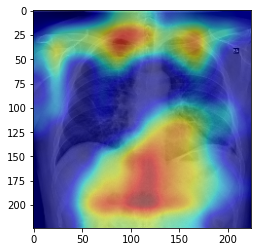

Ground Truth Label:  2
Prediction Label:  2


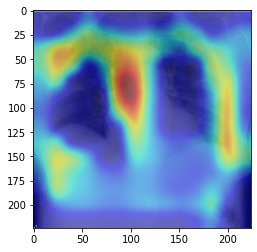

Ground Truth Label:  2
Prediction Label:  2


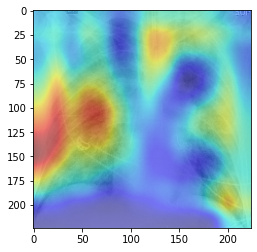

Ground Truth Label:  2
Prediction Label:  2


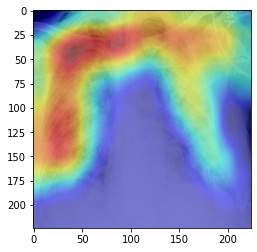

Ground Truth Label:  2
Prediction Label:  0


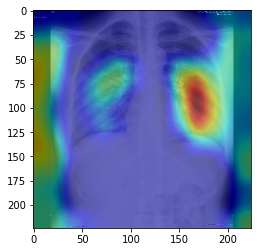

Ground Truth Label:  2
Prediction Label:  1


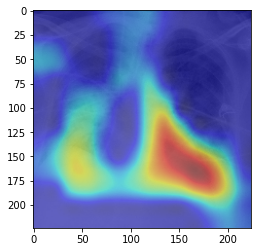

Ground Truth Label:  2
Prediction Label:  1


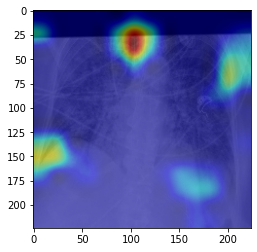

Ground Truth Label:  2
Prediction Label:  2


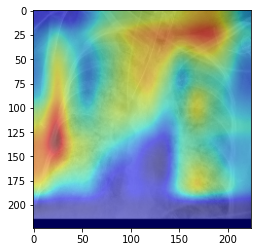

Ground Truth Label:  2
Prediction Label:  2


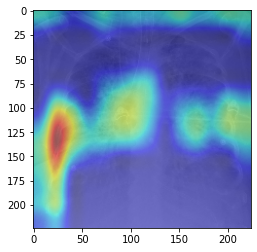

Ground Truth Label:  2
Prediction Label:  2


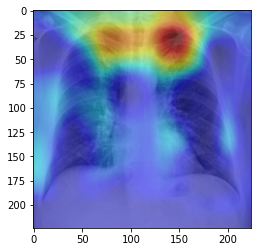

Ground Truth Label:  2
Prediction Label:  2


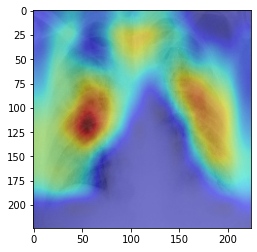

Ground Truth Label:  2
Prediction Label:  2


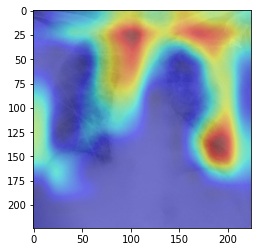

Ground Truth Label:  2
Prediction Label:  2


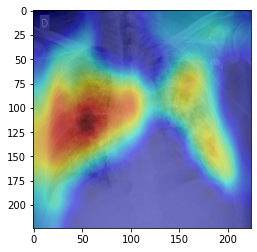

Ground Truth Label:  2
Prediction Label:  2


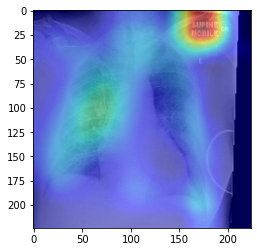

Ground Truth Label:  2
Prediction Label:  2


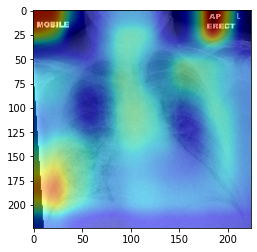

Ground Truth Label:  2
Prediction Label:  2


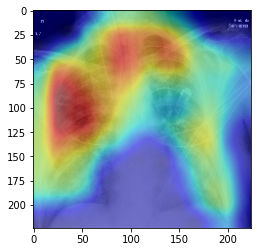

Ground Truth Label:  2
Prediction Label:  2


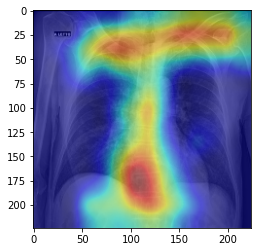

Ground Truth Label:  2
Prediction Label:  2


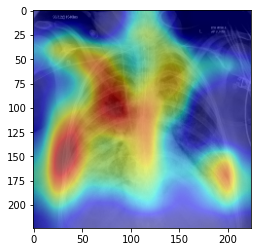

Ground Truth Label:  2
Prediction Label:  2


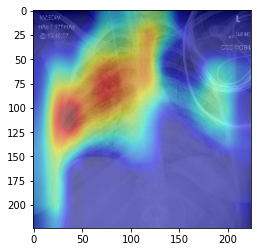

Ground Truth Label:  2
Prediction Label:  2


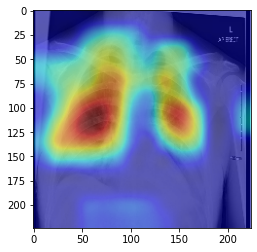

Ground Truth Label:  2
Prediction Label:  2


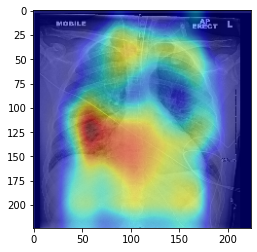

Ground Truth Label:  2
Prediction Label:  2


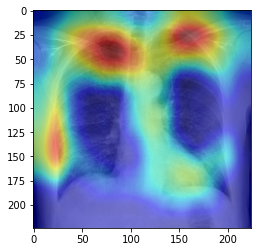

Ground Truth Label:  2
Prediction Label:  2


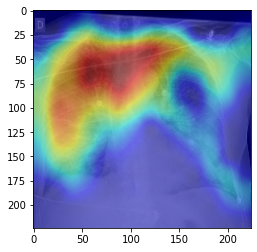

Ground Truth Label:  2
Prediction Label:  2


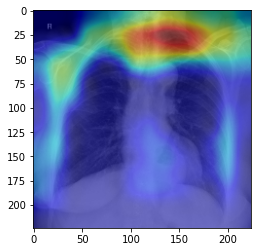

Ground Truth Label:  2
Prediction Label:  2


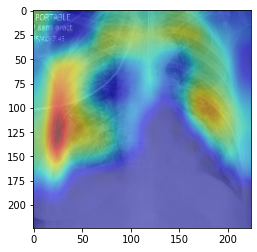

In [0]:
# plot all correct covid19 predictions
for i in covid19:
  plot_grad_cam(testX[i], test_y[i], preds[i])

Ground Truth Label:  0
Prediction Label:  0


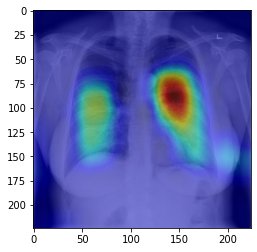

Ground Truth Label:  0
Prediction Label:  0


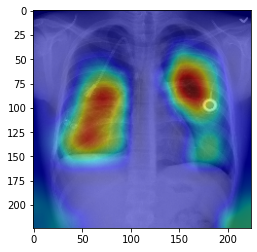

Ground Truth Label:  0
Prediction Label:  0


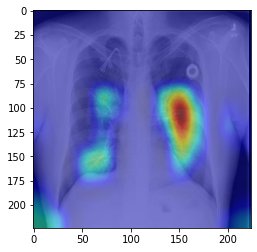

Ground Truth Label:  0
Prediction Label:  0


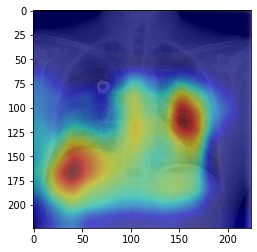

Ground Truth Label:  0
Prediction Label:  0


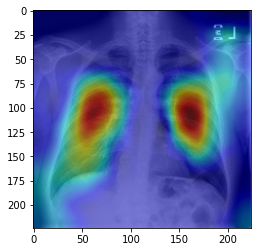

Ground Truth Label:  0
Prediction Label:  0


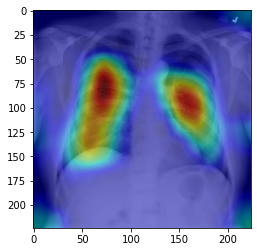

Ground Truth Label:  0
Prediction Label:  0


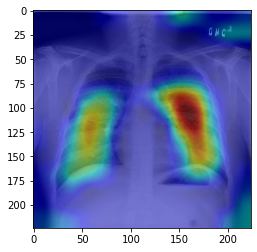

Ground Truth Label:  0
Prediction Label:  0


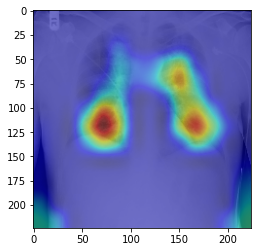

Ground Truth Label:  0
Prediction Label:  0


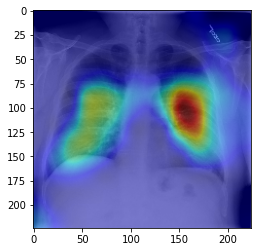

Ground Truth Label:  0
Prediction Label:  1


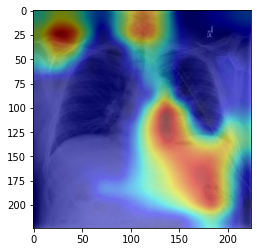

In [0]:
# plot all correct healthy predictions
for i in range(10):
  plot_grad_cam(testX[healthy[i]], test_y[healthy[i]], preds[healthy[i]])

Ground Truth Label:  1
Prediction Label:  1


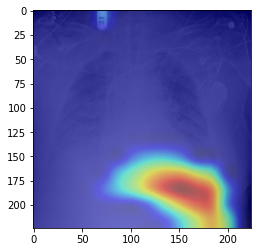

Ground Truth Label:  1
Prediction Label:  1


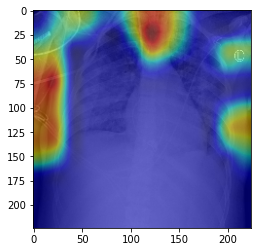

Ground Truth Label:  1
Prediction Label:  0


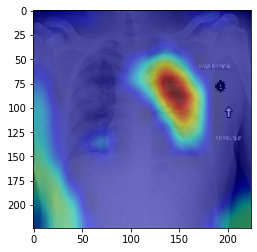

Ground Truth Label:  1
Prediction Label:  1


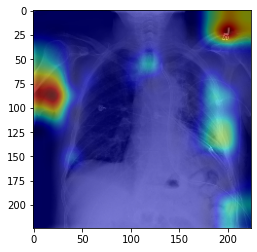

Ground Truth Label:  1
Prediction Label:  1


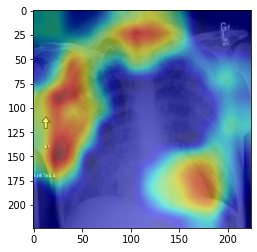

Ground Truth Label:  1
Prediction Label:  0


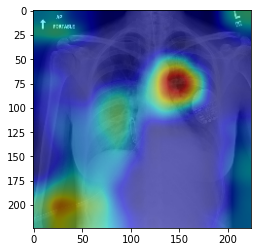

Ground Truth Label:  1
Prediction Label:  0


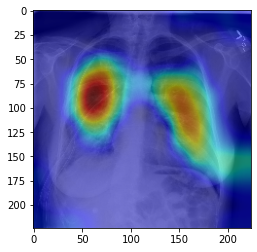

Ground Truth Label:  1
Prediction Label:  1


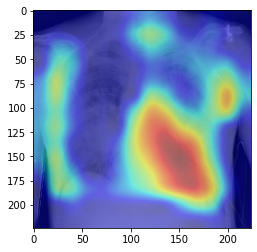

Ground Truth Label:  1
Prediction Label:  1


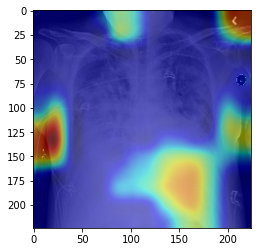

Ground Truth Label:  1
Prediction Label:  1


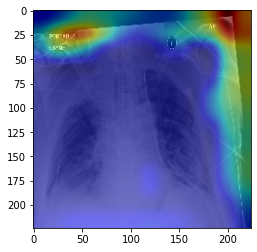

In [0]:
# plot all correct pneumonia predictions
for i in range(10):
  plot_grad_cam(testX[pneumonia[i]], test_y[pneumonia[i]], preds[pneumonia[i]])